In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# import DeepEye analysis functions
from deepeye_analysis_package.preprocessing import getFixationLatency, handle_carryover_fixations_and_merge, addAOI
from deepeye_analysis_package.plotting import plot2d



In [2]:
# Get saccade latency

def getSaccLat(df, fn, plot=True):    

    # Get timestamp of when target was presented and add it to the dataframe

    # 1) get the first time sample when the target is presented
    sampTime_df = df.drop_duplicates(subset=['trialNr'],  keep='first', ignore_index=True)

    # 2)extract the columns needed
    sampTime_df = sampTime_df[['trialNr', 'sampTime']]

    # 3) rename the columns so they would be added
    sampTime_df.columns = ['trialNr', 'targSampTime']

    # 4) merge the target time into the main df (one time per trial)
    df = pd.merge(df, sampTime_df, on="trialNr")

    # Extract saccade latencies

    # 1) select only rows where fixation started
    sl_df = df[df.FixStartEnd == 'fix_start']

    # 2) select only rows with large enough preceeding saccade
    sl_df = sl_df[sl_df.DistFromPrevFix > 300]

    # 3) compute first fixation duration (saccade latency)
    sl_df['SaccLat'] = sl_df.PrevFixSampTime - sl_df.targSampTime

    # 4) remove rows where negative Saccade Latencies for trials where no fixation end is present
    sl_df = sl_df[sl_df.SaccLat > 0]

    if plot == True:
        # Plot the histogram of saccade latencies
        plt.figure()
        plt.title(f'{fn}')
        plt.style.use('ggplot')
        plt.hist(sl_df.SaccLat)
        plt.xlabel('Saccade latency (ms)')
    
    return sl_df



In [3]:
# path_to_data = r'C:/Users/aby600/Dropbox/Appliedwork/CognitiveSolutions/Projects/DeepEye/TechnicalReports/TechnicalReport1/Test_MullerLyer/pilot3'
path_to_data = r'D:/Dropbox/Appliedwork/CognitiveSolutions/Projects/DeepEye/TechnicalReports/TechnicalReport1/Test_MullerLyer/pilot3'

Processing participant 2024_10_16_12_33_59...


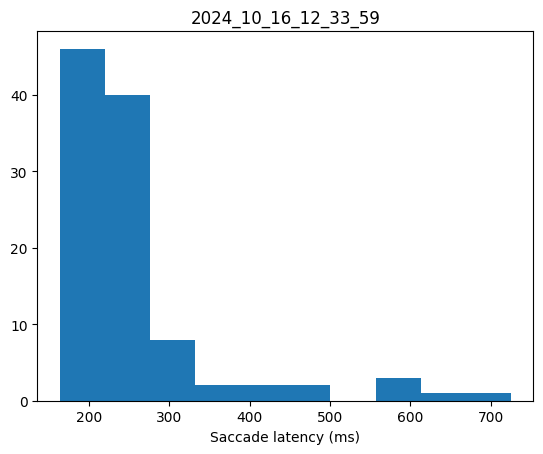

In [4]:
from deepeye_analysis_package.getFixations import extract_fixations

# Initialize an empty list to hold the processed dataframes
output_dfs = []

# Get all folder names from the data directory
folder_names = [name for name in os.listdir(path_to_data) if os.path.isdir(os.path.join(path_to_data, name))]

# Process each participant's data
for fn in folder_names:
    # Check if _record_extra.csv exists, if not use _record.csv
    path_to_file = os.path.join(path_to_data, fn, f'{fn}_record_extra.csv')
    if not os.path.exists(path_to_file):
        path_to_file = os.path.join(path_to_data, fn, f'{fn}_record.csv')

        print(f'Extracting fixations for participant {fn}...')

        try:
            df = pd.read_csv(path_to_file)
            df = extract_fixations(df, path_to_file)
        except FileNotFoundError:
            print(f'File does not exist: {path_to_file}')
            continue    
    else: 
        try:
            df = pd.read_csv(path_to_file)
        except FileNotFoundError:
            print(f'File does not exist: {path_to_file}')
            continue

    print(f'Processing participant {fn}...')
    # Filter data to only include rows where the target was presented
    df1 = df[df['event'] == 'target_on'].copy()

    # Add subject ID to the dataframe
    df1['deepeye_id'] = fn

    # Label trials with too few data points
    sperTrial_df = df1.groupby('trialNr').count().reset_index()
    sperTrial_df = sperTrial_df[['trialNr', 'sampTime']]
    # Rename the columns so they would be added
    sperTrial_df.columns = ['trialNr', 'samplesPerTrial']
    df1 = pd.merge(df1, sperTrial_df, on="trialNr")

    # Get saccade latencies
    sl_df = getSaccLat(df1, fn, plot=True)

    # Merge saccade latencies into main df
    sl_df = sl_df[['trialNr', 'SaccLat']]
    df1 = pd.merge(df1, sl_df, on="trialNr")

    # Accumulate the processed dataframe for this participant
    output_dfs.append(df1)

# # Concatenate all participants' data into one DataFrame
# if output_dfs:
#     output_df = pd.concat(output_dfs, ignore_index=True)
#     output_file = os.path.join(path_to_analysis, 'allSubjects_ML.csv')
#     output_df.to_csv(output_file, index=False)
#     print(f'Combined data saved to {output_file}')
# else:
#     print('No data was processed.')


In [5]:
def plot_fixationsOutIn(df, cond='', agg='median', title=''):
    
    plt.style.use('ggplot')  
    
    out = df[df.condition=='arrowHeadsOutward']
    inw = df[df.condition=='arrowHeadsInward']

    if agg=='median':
        
        outX = out.FixXPos.median()
        outY = out.FixYPos.median()

        inwX = inw.FixXPos.median()
        inwY = inw.FixYPos.median()
        
    elif agg=='mean':
        
        outX = out.FixXPos.mean()
        outY = out.FixYPos.mean()

        inwX = inw.FixXPos.mean()
        inwY = inw.FixYPos.mean()
        
        

    plt.figure()    
    plt.title(title);
    
    
    out_h = plt.scatter(out.FixXPos, out.FixYPos, c='blue', alpha=0.5, edgecolors='black')
    inw_h = plt.scatter(inw.FixXPos, inw.FixYPos, c='orange', alpha=0.5,edgecolors='black')
    
    # plt.scatter(out.fixationStimX, out.fixationStimY, c='red')
    targ_h = plt.scatter(out.targetX, out.fixationStimY, c='green')
    
    
    # plot target and fixation vertical lines
    # plt.plot(np.ones(df.resY.iloc[0].astype('int')) * df.fixationStimX.iloc[0], np.arange(df.resY.iloc[0]), c='red', lw=1, linestyle='dashed')
    plt.plot(np.ones(df.resY.iloc[0].astype('int')) * df.targetX.iloc[0], np.arange(df.resY.iloc[0]), c='green', lw=1, linestyle='dashed')    

    plt.scatter(outX, outY, c='purple', edgecolors='black')
    plt.scatter(inwX, inwY, c='darkorange', edgecolors='black')
    
    # plot inward and outward vertical lines
    plt.plot(np.ones(df.resY.iloc[0].astype('int')) * outX, np.arange(df.resY.iloc[0]), c='purple', lw=1, linestyle='dashed')
    plt.plot(np.ones(df.resY.iloc[0].astype('int')) * inwX, np.arange(df.resY.iloc[0]), c='darkorange', lw=1, linestyle='dashed')    
    
    # plt.xlim((0, df.resX.iloc[0]))
    # plt.ylim((df.resY.iloc[0], 0))
    
    plt.xlabel('Horizontal eye position (pixels)')
    plt.ylabel('Vertical eye position (pixels)')
    
    plt.legend((out_h, inw_h, targ_h), (f'<-> outward arrowheads {np.round(outX,1)}px', f'>-< inward arrowheads {np.round(inwX,1)}px', 'target'), scatterpoints=1)
    
    
    # plt.text(150,700,f'Outward Arrow Xpos: {np.round(outX,1)}')
    # plt.text(150,750,f'Inward Arrow Xpos: {np.round(outX,1)}')
    
    # save figure
#     plt.savefig(f'./Figures_MullerLyer/{cond}_OutInw.jpg', dpi=1000, pad_inches=0)


    return outX, outY, inwX, inwY



Target Left Outward Arrow: 730.733449315572
Target Left Inward Arrow: 714.079583778555
Target Right Outward Arrow: 1246.1431919194674
Target Right Inward Arrow: 1247.051071449396


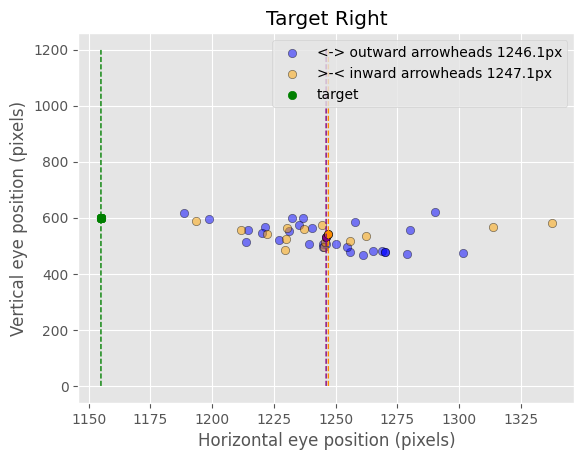

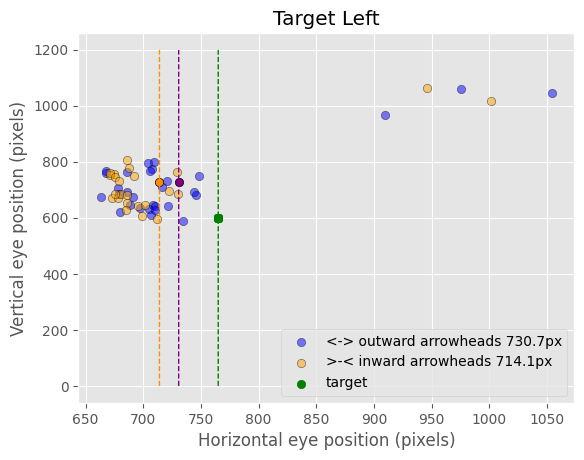

In [6]:
# Min distance from fixaton to target or fixation point in pixels
pix_in_cm = df1.resX.iloc[0]/df.scrW_cm.iloc[0]
minDist = pix_in_cm * 15

# select rows where fixation started (they also have information about when previous fixation ended)
i_df = df1[df1.FixStartEnd == 'fix_start']

# get samples with large enough preceeding saccade
i_df = i_df[i_df.DistFromPrevFix > 300]

# select rows where Saccade Latencies are positive (negative menas that trials have no fixation end is present)
i_df = i_df[i_df.SaccLat > 50]

# select rows where Saccade latencies are fast
i_df = i_df[i_df.SaccLat < 300]

# select rows where Saccade lands close to the target
targets = np.c_[np.array(i_df.targetX), np.array(i_df.fixationStimY)] # get a target vector
fixations = np.c_[np.array(i_df.FixXPos), np.array(i_df.FixYPos)] # get a fixation vector
# DistFix2Targ = np_euclidean_distance(targets, fixations) # compute vector of distances from fixation to target
DistFix2Targ = np.linalg.norm(targets - fixations, axis=1)
i_df['DistFix2Targ'] = DistFix2Targ
i_df = i_df[i_df.DistFix2Targ <= minDist]

# select rows where Saccade starts close to the fixation point
fixation_points = np.c_[np.array(i_df.fixationStimX), np.array(i_df.fixationStimY)] # get a fixation points vector
prev_fixations = np.c_[np.array(i_df.PrevFixXPos), np.array(i_df.PrevFixYPos)] # get a fixation vector of first fixations in the trial (when fixating the fixation point)
# DistPrevFix2FixPoint = np_euclidean_distance(fixation_points, prev_fixations) # compute vector of distances from previous fixation to fixation point
DistPrevFix2FixPoint = np.linalg.norm(fixation_points - prev_fixations, axis=1)

i_df['DistPrevFix2FixPoint'] = DistPrevFix2FixPoint
i_df = i_df[i_df.DistPrevFix2FixPoint <= minDist]

# filter out trials with too few samples
# i_df = i_df[i_df.samplesPerTrial > 0]

Left = i_df[i_df.target=='left']
out = Left[Left.condition=='arrowHeadsOutward']
inw = Left[Left.condition=='arrowHeadsInward']
print(f'Target Left Outward Arrow: {out.FixXPos.mean()}')
print(f'Target Left Inward Arrow: {inw.FixXPos.mean()}')

Right = i_df[i_df.target=='right']
out = Right[Right.condition=='arrowHeadsOutward']
inw = Right[Right.condition=='arrowHeadsInward']
print(f'Target Right Outward Arrow: {out.FixXPos.mean()}')
print(f'Target Right Inward Arrow: {inw.FixXPos.mean()}')


# Plot
summary_right = plot_fixationsOutIn(Right, cond='right', agg='mean', title='Target Right')
summary_left = plot_fixationsOutIn(Left, cond='left', agg='mean', title='Target Left')

